In [35]:
#Imports
import pandas as pd
import numpy as np
import matplotlib as plt
import IPython
import ipywidgets as widgets
import random
import seaborn
import plotly
from IPython.display import clear_output
from io import BytesIO

In [36]:
#Loading csv file
def handle_upload(change):
    global df
    clear_output()
    if isinstance(upload_button.value, dict) and upload_button.value:
        uploaded_filename = list(upload_button.value.keys())[0]
        uploaded_file_data = upload_button.value[uploaded_filename]

        content = BytesIO(uploaded_file_data['content'])

        try:
            df = pd.read_csv(content)
            print(f"File '{uploaded_filename}' uploaded successfully.")
            rows_input.disabled = False
            order_dropdown.disabled = False
            display(widgets.VBox([rows_input, order_dropdown, output_area]))
        except Exception as e:
            print(f"Error reading file: {e}")
            rows_input.disabled = True
            order_dropdown.disabled = True
            df = None
    else:
        print("No file uploaded or upload value is not in the expected format.")
        rows_input.disabled = True
        order_dropdown.disabled = True
        df = None

upload_button = widgets.FileUpload(
    accept='.csv',
    multiple=False
)

rows_input = widgets.Text(
    placeholder='Enter number of rows',
    disabled=True
)

order_dropdown = widgets.Dropdown(
    options=['In Order', 'Random'],
    value='In Order',
    description='Row Order:',
    disabled=True
)

output_area = widgets.Output()

df = None

def display_dataframe(b=None):
    global df
    with output_area:
        clear_output()
        if df is not None:
            try:
                num_rows_str = rows_input.value.lower()
                if num_rows_str == 'all':
                    num_rows = len(df)
                else:
                    num_rows = int(num_rows_str)

                if num_rows > len(df):
                    print(f"Warning: Requested {num_rows} rows, but only {len(df)} available. Displaying all rows.")
                    num_rows = len(df)

                if order_dropdown.value == 'Random':
                    if num_rows == len(df):
                         display(df)
                    else:
                        display(df.sample(n=num_rows))
                else:
                    display(df.head(num_rows))
            except ValueError:
                print("Please enter a valid number or 'all'.")
            except Exception as e:
                print(f"An error occurred: {e}")

upload_button.observe(handle_upload, names='value')
rows_input.observe(display_dataframe, names='value')
order_dropdown.observe(display_dataframe, names='value')

display(upload_button)

File 'churn.csv' uploaded successfully.


In [37]:
# Step 2: Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Handle missing/invalid TotalCharges
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
else:
    print("Warning: 'TotalCharges' column not found.")

# Drop customerID (identifier) if it exists
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')
for col in cat_cols:
    # Check if column exists and has data before encoding
    if col in df.columns and not df[col].empty:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    elif col in df.columns and df[col].empty:
        print(f"Warning: Column '{col}' is empty, skipping encoding.")


# Encode target
if 'Churn' in df.columns:
  # Convert 'Churn' to numeric, coercing errors to NaN, then drop rows with NaN
  df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})
  df.dropna(subset=['Churn'], inplace=True)
  # Check if df is empty after dropping NaNs
  if df.empty:
      print("Error: DataFrame is empty after dropping rows with missing Churn values.")
  else:
    df['Churn'] = df['Churn'].astype(int)
else:
    print("Warning: 'Churn' column not found.")


# Optional: Scale numeric features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
# Check if df is empty before scaling
if not df.empty:
  for col in num_cols:
    if col in df.columns:
      # Check if column has data before scaling
      if not df[col].empty:
        df[col] = scaler.fit_transform(df[[col]])
      else:
        print(f"Warning: Column '{col}' is empty, skipping scaling.")
    else:
        print(f"Warning: Column '{col}' not found for scaling.")

else:
  print("Skipping scaling because DataFrame is empty.")

Training data shape: (205, 20)
Testing data shape: (52, 20)

Training Decision Tree Model...
Decision Tree Model trained.

Evaluating Decision Tree Model...
Decision Tree Model Evaluation:
Accuracy: 0.7308
ROC AUC: 0.6493
Confusion Matrix:
[[31  5]
 [ 9  7]]


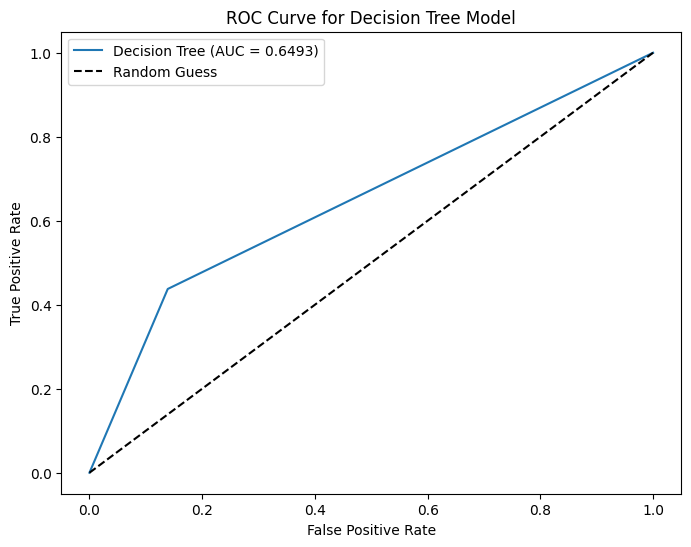

# Task
Perform data preprocessing (handle null values, encoding, scaling) on the churn dataset, split the data into training and testing sets, create multiple decision tree models using both scikit-learn and a from-scratch implementation, evaluate all models using a metrics table and ROC curves, and interpret the trade-offs between the models.

## Ensure data is preprocessed and split

### Subtask:
Confirm that the data has been successfully preprocessed (handling missing values, encoding, scaling) and split into training and testing sets (`X_train`, `X_test`, `y_train`, `y_test`) and that these are not empty.


**Reasoning**:
Print the shapes of the training and testing sets and display the head of the training sets to confirm successful preprocessing and splitting.



In [40]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nFirst 5 rows of X_train:")
display(X_train.head())

print("\nFirst 5 rows of y_train:")
display(y_train.head())

Shape of X_train: (205, 20)
Shape of X_test: (52, 20)
Shape of y_train: (205,)
Shape of y_test: (52,)

First 5 rows of X_train:


,Unnamed: 0,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
70,71,0.998220,2,0,0,1.673237,2.663900,1,0.0,1,2,1,2,1,2,2,2,2,2,2
14,15,-0.649511,0,0,3,-1.352827,-0.647375,0,0.0,1,2,1,0,2,1,1,1,1,1,1
218,219,1.410153,0,0,3,-1.216010,-0.989640,0,0.0,0,2,0,1,0,0,0,0,0,0,0
229,230,0.403206,0,1,2,0.554559,-0.775699,1,1.0,0,1,1,0,1,0,0,0,0,2,0
76,77,0.769369,2,0,0,0.655964,1.612470,1,0.0,1,2,1,0,0,2,2,0,2,2,2



First 5 rows of y_train:


,Churn
70,0
14,0
218,0
229,0
76,0


## Train decision tree models (using library)

### Subtask:
Train several Decision Tree models using scikit-learn with different hyperparameters to explore their performance.


**Reasoning**:
Train several Decision Tree models with different hyperparameters as specified in the instructions.



In [42]:
from sklearn.tree import DecisionTreeClassifier

# List to store trained models
trained_dt_models = []

# List of hyperparameter dictionaries
hyperparameters_list = [
    {'max_depth': 3, 'min_samples_split': 5, 'criterion': 'gini', 'random_state': 42},
    {'max_depth': 5, 'min_samples_split': 10, 'criterion': 'entropy', 'random_state': 42},
    {'max_depth': None, 'min_samples_split': 2, 'criterion': 'gini', 'random_state': 42} # Default hyperparameters for comparison
]

# Iterate and train models
for params in hyperparameters_list:
    print(f"Training Decision Tree with hyperparameters: {params}")
    dt_model = DecisionTreeClassifier(**params)
    dt_model.fit(X_train, y_train)
    trained_dt_models.append(dt_model)
    print("Model trained.")

print(f"\nSuccessfully trained {len(trained_dt_models)} Decision Tree models.")

Training Decision Tree with hyperparameters: {'max_depth': 3, 'min_samples_split': 5, 'criterion': 'gini', 'random_state': 42}
Model trained.
Training Decision Tree with hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'criterion': 'entropy', 'random_state': 42}
Model trained.
Training Decision Tree with hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'criterion': 'gini', 'random_state': 42}
Model trained.

Successfully trained 3 Decision Tree models.


## Implement decision tree from scratch

### Subtask:
Write Python code to build a Decision Tree model from the ground up. This will involve implementing concepts like calculating impurity (Gini impurity or entropy), finding the best split point, and recursively building the tree.


**Reasoning**:
Define the Decision Tree class with methods for impurity calculation, best split finding, recursive tree building, and prediction, implementing the core logic for a decision tree model from scratch.



In [49]:
from collections import Counter
import numpy as np

class Node:
    """Represents a node in the Decision Tree."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold          # Threshold value for the split
        self.left = left                    # Left child node (samples <= threshold)
        self.right = right                  # Right child node (samples > threshold)
        self.value = value                  # Class label if the node is a leaf node

class DecisionTree:
    """Decision Tree classifier from scratch."""
    def __init__(self, max_depth=5, min_samples_split=2, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.root = None

    def _gini_impurity(self, y):
        """Calculates the Gini impurity of a set of labels."""
        if len(y) == 0:
            return 0
        class_counts = Counter(y)
        impurity = 1.0
        for label in class_counts:
            prob_of_label = class_counts[label] / len(y)
            impurity -= prob_of_label**2
        return impurity

    def _entropy(self, y):
        """Calculates the Entropy of a set of labels."""
        if len(y) == 0:
            return 0
        class_counts = Counter(y)
        entropy = 0.0
        total_samples = len(y)
        for label in class_counts:
            prob_of_label = class_counts[label] / total_samples
            entropy -= prob_of_label * np.log2(prob_of_label)
        return entropy

    def _calculate_impurity(self, y):
        """Wrapper to calculate impurity based on the chosen criterion."""
        if self.criterion == 'gini':
            return self._gini_impurity(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
        else:
            raise ValueError("Invalid criterion. Choose 'gini' or 'entropy'.")

    def _information_gain(self, parent_y, left_y, right_y):
        """Calculates the information gain from a split."""
        parent_impurity = self._calculate_impurity(parent_y)
        n = len(parent_y)
        n_left, n_right = len(left_y), len(right_y)
        if n == 0: # Avoid division by zero
            return 0
        weighted_child_impurity = (n_left / n) * self._calculate_impurity(left_y) + (n_right / n) * self._calculate_impurity(right_y)
        return parent_impurity - weighted_child_impurity

    def _find_best_split(self, X, y):
        """Finds the best split point (feature and threshold) for the data."""
        best_gain = -1
        best_split = None

        n_samples, n_features = X.shape

        for feature_index in range(n_features):
            unique_values = np.unique(X[:, feature_index])
            for threshold in unique_values:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices

                y_left, y_right = y[left_indices], y[right_indices]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = self._information_gain(y, y_left, y_right)

                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_index, threshold)

        return best_split

    def _build_tree(self, X, y, depth):
        """Recursively builds the Decision Tree."""
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        # Check if max_depth is not None before comparing
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < self.min_samples_split:
            # Handle case where y might be empty for leaf node
            if len(y) == 0:
                return Node(value=None) # Or a default class if appropriate
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        best_split = self._find_best_split(X, y)

        # Handle case where no good split is found or data is empty
        if best_split is None or len(y) == 0:
             # Handle case where y might be empty
             if len(y) == 0:
                 return Node(value=None) # Or a default class if appropriate
             leaf_value = Counter(y).most_common(1)[0][0]
             return Node(value=leaf_value)


        feature_index, threshold = best_split

        left_indices = X[:, feature_index] <= threshold
        right_indices = ~left_indices

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # Handle cases where a split results in empty left or right child
        if len(X_left) == 0 or len(X_right) == 0:
             if len(y) == 0:
                 return Node(value=None)
             leaf_value = Counter(y).most_common(1)[0][0]
             return Node(value=leaf_value)


        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        return Node(feature_index=feature_index, threshold=threshold,
                    left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        """Trains the Decision Tree model."""
        # Ensure X and y are numpy arrays for consistent indexing
        X_np = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)
        y_np = y.values if isinstance(y, pd.Series) else np.asarray(y)

        self.root = self._build_tree(X_np, y_np, depth=0)

    def _predict_single(self, x, node):
        """Predicts the class label for a single data point."""
        if node.value is not None:
            return node.value

        # Ensure x is indexable like a numpy array
        x_np = np.asarray(x)

        feature_value = x_np[node.feature_index]

        if feature_value <= node.threshold:
            # Check if left child exists before recursing
            if node.left:
              return self._predict_single(x_np, node.left)
            else:
              # If no left child, return the majority class of the current node's data
              # This case should ideally not happen if _build_tree is correct,
              # but as a safeguard, return a default or the parent's majority
              # For now, returning None or raising an error might be better for debugging
              return None # Or a default class

        else:
            # Check if right child exists before recursing
            if node.right:
                return self._predict_single(x_np, node.right)
            else:
                 # If no right child, return the majority class of the current node's data
                 return None # Or a default class


    def predict(self, X):
        """Predicts the class labels for multiple data points."""
        # Ensure X is a numpy array for consistent iteration and indexing
        X_np = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

        predictions = [self._predict_single(x, self.root) for x in X_np]
        return np.array(predictions)

Evaluating scikit-learn Decision Tree Models...

Evaluating From-Scratch Decision Tree Model...
Error evaluating From-Scratch DT Model: 'bool' object has no attribute 'any'

--- Model Evaluation Metrics ---


,Model,Accuracy,ROC AUC,Confusion Matrix
0,Sklearn DT Model 1,0.730769,0.750868,"[[28, 8], [6, 10]]"
1,Sklearn DT Model 2,0.750000,0.794271,"[[29, 7], [6, 10]]"
2,Sklearn DT Model 3,0.730769,0.649306,"[[31, 5], [9, 7]]"



--- ROC Curves ---


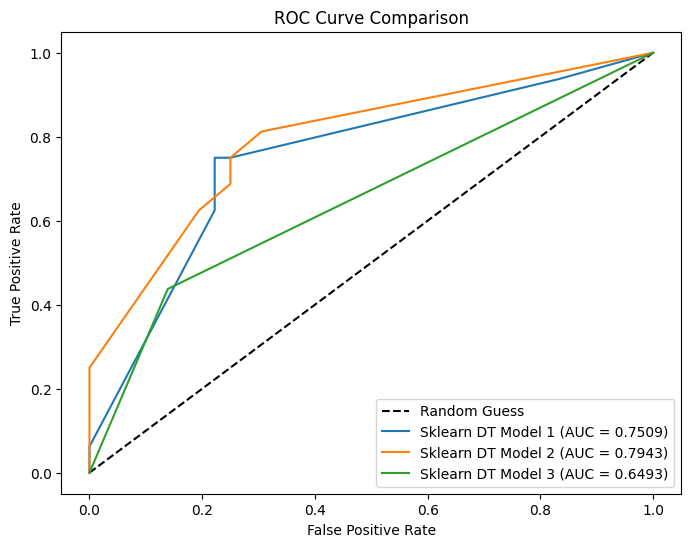

In [52]:
# Step 5, 6 & 7: Evaluate all models, Create metrics table, Plot ROC curves

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# Check if test data is available and not empty
if 'X_test' in globals() and 'y_test' in globals() and not X_test.empty and not y_test.empty:

    # List to store evaluation results
    evaluation_results = []

    # Evaluate scikit-learn models (assuming trained_dt_models list exists from Step 2)
    if 'trained_dt_models' in globals() and trained_dt_models:
        print("Evaluating scikit-learn Decision Tree Models...")
        for i, model in enumerate(trained_dt_models):
            model_name = f"Sklearn DT Model {i+1}"
            try:
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]

                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)
                conf_matrix = confusion_matrix(y_test, y_pred)

                evaluation_results.append({
                    'Model': model_name,
                    'Accuracy': accuracy,
                    'ROC AUC': roc_auc,
                    'Confusion Matrix': conf_matrix.tolist() # Store as list for table
                })

            except Exception as e:
                print(f"Error evaluating {model_name}: {e}")

    # Evaluate from-scratch model (assuming dt_model_scratch exists from Step 4)
    if 'dt_model_scratch' in globals() and dt_model_scratch.root is not None:
        print("\nEvaluating From-Scratch Decision Tree Model...")
        model_name = "From-Scratch DT Model"
        try:
            # For the from-scratch model, we only have predict, not predict_proba.
            # ROC AUC requires probabilities. We'll skip ROC AUC for the from-scratch model for now,
            # or implement probability prediction in the scratch model if needed later.
            y_pred_scratch = dt_model_scratch.predict(X_test)

            # Filter out None predictions if any occurred
            valid_indices = y_pred_scratch is not None
            if valid_indices.any():
                y_test_valid = y_test[valid_indices]
                y_pred_scratch_valid = y_pred_scratch[valid_indices]


                accuracy_scratch = accuracy_score(y_test_valid, y_pred_scratch_valid)
                conf_matrix_scratch = confusion_matrix(y_test_valid, y_pred_scratch_valid)

                evaluation_results.append({
                    'Model': model_name,
                    'Accuracy': accuracy_scratch,
                    'ROC AUC': 'N/A (requires probability)', # Indicate lack of probability prediction
                    'Confusion Matrix': conf_matrix_scratch.tolist()
                })
            else:
                 print("From-scratch model returned no valid predictions.")


        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")


    # Create Metrics Table
    if evaluation_results:
        metrics_df = pd.DataFrame(evaluation_results)
        print("\n--- Model Evaluation Metrics ---")
        display(metrics_df)
    else:
        print("\nNo evaluation results available.")

    # Plot ROC Curves (only for models with probability prediction)
    print("\n--- ROC Curves ---")
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Random guess line

    if 'trained_dt_models' in globals() and trained_dt_models:
        for i, model in enumerate(trained_dt_models):
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_test, y_proba)
                roc_auc = roc_auc_score(y_test, y_proba)
                plt.plot(fpr, tpr, label=f'Sklearn DT Model {i+1} (AUC = {roc_auc:.4f})')
            except Exception as e:
                print(f"Could not plot ROC for Sklearn DT Model {i+1}: {e}")


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.show()

else:
    print("Test data (X_test, y_test) is not available or is empty. Cannot perform evaluation.")